In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
import gc
#from talos.model.layers import hidden_layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv1D, Reshape
from keras.callbacks import ModelCheckpoint, History
from keras.activations import relu, elu, linear
from keras import backend as K
from keras import regularizers
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from tqdm import trange

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18

2.0.0


In [3]:
data_pd = pd.read_pickle("../data/credit_card_cleaned.pickle")
data = data_pd.to_numpy(); data_pd

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,0,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21303,210000,1,2,1,34,3,2,2,2,2,...,2500,2500,2500,0,0,0,0,0,0,1
21304,10000,1,3,1,43,0,0,0,0,0,...,0,0,0,2000,0,0,0,0,0,0
21305,80000,1,2,2,34,2,2,2,2,2,...,77519,82607,81158,7000,3500,0,7000,0,4000,1
21306,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0


In [4]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

In [5]:
input_data = data[:,:-1]
output_data = data[:,-1]
nr_params = input_data.shape[1]; nr_datapoints = input_data.shape[0]; nr_params, nr_datapoints

(23, 21308)

In [6]:
all_params = {
    "hidden_layers" : [1, 2, 4],
    "neurons" : [4, 8, 16, 32],
    "epochs" : [50, 100, 200],
    "lr" : [0.01, 0.001, 0.0001]
}
nr_runs = np.prod([len(nr) for nr in all_params.values()])
nr_runs

108

In [7]:
def make_model(params):
    opti = optimizers.Adam(amsgrad=True)
    def nn_reg():
        model = Sequential()
        model.add(Dense(params["neurons"], input_shape=(nr_params,), activation="linear", kernel_initializer='random_uniform'))
        for i in range(params["hidden_layers"] - 1):
            model.add(Dense(params["neurons"], activation="relu", kernel_initializer='random_uniform'))
        model.add(Dense(1, activation="sigmoid", kernel_initializer='random_uniform'))
        model.compile(optimizer=opti, loss="binary_crossentropy",  metrics=["accuracy"])
        return model
    return nn_reg

In [7]:
hp_dict = {
    "area_score" : [],
    "area_std" : [],
    "acc_score" : [],
    "acc_std" : [],
    "hidden_layers" : [],
    "neurons" : [],
    "lr" : [],
    "epochs" : []
}

nr_averages = 40

k = 0
t0 = time.time()
for hidden_layers in all_params["hidden_layers"]:
    for neurons in all_params["neurons"]:
        for epochs in all_params["epochs"]:
            for lr in all_params["lr"]:

                params = {
                    "hidden_layers" : hidden_layers,
                    "neurons" : neurons,
                    "epochs" : epochs,
                    "lr" : lr
                         }

                hp_dict["hidden_layers"].append(hidden_layers)
                hp_dict["neurons"].append(neurons)
                hp_dict["epochs"].append(epochs)
                hp_dict["lr"].append(lr)

                area = 0
                area2 = 0
                acc = 0
                acc2 = 0
                for i in range(nr_averages):

                    X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data, test_size=0.1)
                    
                    Scaler = preprocessing.StandardScaler()
                    X_train_scaled = Scaler.fit_transform(X_train)
                    X_test_scaled = Scaler.transform(X_test)
                    
                    model = make_model(params)
                    reg = KerasRegressor(build_fn=model, batch_size=256, epochs=epochs, validation_split=0, verbose=0)
                    history = reg.fit(X_train_scaled, Y_train)
                    Y_pred = reg.predict(X_test_scaled)
                    area += roc_auc_score(Y_test, np.where(Y_pred > 0.5, 1, 0))
                    area2 += roc_auc_score(Y_test, np.where(Y_pred > 0.5, 1, 0))**2
                    acc += accuracy_score(Y_test, np.where(Y_pred > 0.5, 1, 0))
                    acc2 += accuracy_score(Y_test, np.where(Y_pred > 0.5, 1, 0))**2
                    # plt.plot(history.history["accuracy"])
                    del history, reg, model
                    gc.collect()
                    K.clear_session()

                hp_dict["area_score"].append(area/nr_averages)
                hp_dict["area_std"].append(area2/nr_averages)  # Placeholder for std. Atm just <area^2>.
                hp_dict["acc_score"].append(acc/nr_averages)
                hp_dict["acc_std"].append(acc2/nr_averages)  # Placeholder for std. Atm just <area^2>.
                

                k += 1
                print(f"{100*k/nr_runs:.1f} %, {(time.time()-t0)/60:.1f} m")


0.9 %, 2.1 m
1.9 %, 4.2 m
2.8 %, 6.4 m
3.7 %, 10.8 m
4.6 %, 15.2 m
5.6 %, 19.7 m
6.5 %, 28.3 m
7.4 %, 37.9 m
8.3 %, 45.5 m
9.3 %, 47.6 m
10.2 %, 49.7 m
11.1 %, 51.8 m
12.0 %, 55.7 m
13.0 %, 59.6 m
13.9 %, 63.5 m
14.8 %, 71.1 m
15.7 %, 78.8 m
16.7 %, 86.5 m
17.6 %, 88.5 m
18.5 %, 90.6 m
19.4 %, 92.7 m
20.4 %, 96.6 m
21.3 %, 100.5 m
22.2 %, 104.4 m
23.1 %, 112.0 m
24.1 %, 119.6 m
25.0 %, 127.2 m
25.9 %, 129.3 m
26.9 %, 131.4 m
27.8 %, 133.5 m
28.7 %, 137.5 m
29.6 %, 141.4 m
30.6 %, 145.5 m
31.5 %, 153.8 m
32.4 %, 161.7 m
33.3 %, 169.9 m
34.3 %, 172.7 m
35.2 %, 175.3 m
36.1 %, 177.7 m
37.0 %, 182.5 m
38.0 %, 187.6 m
38.9 %, 192.2 m
39.8 %, 202.0 m
40.7 %, 211.3 m
41.7 %, 220.2 m
42.6 %, 222.6 m
43.5 %, 225.1 m
44.4 %, 227.7 m
45.4 %, 232.1 m
46.3 %, 236.4 m
47.2 %, 240.7 m
48.1 %, 249.2 m
49.1 %, 258.1 m
50.0 %, 267.6 m
50.9 %, 270.6 m
51.9 %, 273.5 m
52.8 %, 276.2 m
53.7 %, 281.2 m
54.6 %, 285.9 m
55.6 %, 291.6 m
56.5 %, 301.6 m
57.4 %, 312.0 m
58.3 %, 321.2 m
59.3 %, 324.1 m
60.2 %, 329

In [8]:
hp_df = pd.DataFrame(hp_dict).sort_values(by="area_score", ascending=False);
hp_df["area_std"] = hp_df["area_std"] - hp_df["area_score"]**2;
hp_df["acc_std"] = hp_df["acc_std"] - hp_df["acc_score"]**2;
hp_df.to_pickle("../data/CC_hyperparam2.pickle")

In [8]:
hp_df = pd.read_pickle("../data/CC_hyperparam2.pickle")

In [9]:
hp_df

,area_score,area_std,acc_score,acc_std,hidden_layers,neurons,lr,epochs
90,0.670562,0.000097,0.798768,0.000066,4,16,0.0100,50
91,0.666598,0.000056,0.797267,0.000047,4,16,0.0010,50
101,0.666130,0.000231,0.799214,0.000078,4,32,0.0001,50
92,0.665572,0.000093,0.798158,0.000045,4,16,0.0001,50
85,0.664380,0.000245,0.796598,0.000085,4,8,0.0010,100
...,...,...,...,...,...,...,...,...
1,0.622002,0.000105,0.786344,0.000072,1,4,0.0010,50
0,0.621151,0.000108,0.785840,0.000048,1,4,0.0100,50
6,0.620848,0.000123,0.787166,0.000081,1,4,0.0100,200
29,0.619781,0.000128,0.785218,0.000072,1,32,0.0001,50


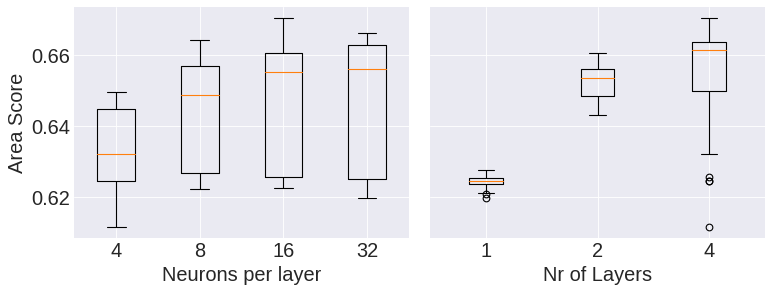

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
asdf = [hp_df[hp_df["neurons"] == i]["area_score"] for i in [4, 8, 16, 32]]
ax[0].boxplot(asdf);
ax[0].set_xlabel("Neurons per layer")
ax[0].set_ylabel("Area Score")
ax[0].set_xticklabels(["4", "8", "16", "32"]);
asdf = [hp_df[hp_df["hidden_layers"] == i]["area_score"] for i in [1, 2, 4]]
ax[1].boxplot(asdf);
ax[1].set_xlabel("Nr of Layers")
ax[1].set_xticklabels(["1", "2", "4"]);
plt.tight_layout()
#plt.savefig("../figs/CC_TF_boxplot.pdf")

In [15]:
lrs = [0.0001, 0.001, 0.01]
epochs = [50, 100, 200]
asdf = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        asdf[i,j] = np.mean(hp_df[(hp_df["epochs"]==epochs[j]) & (hp_df["lr"]==lrs[i])]["area_score"])

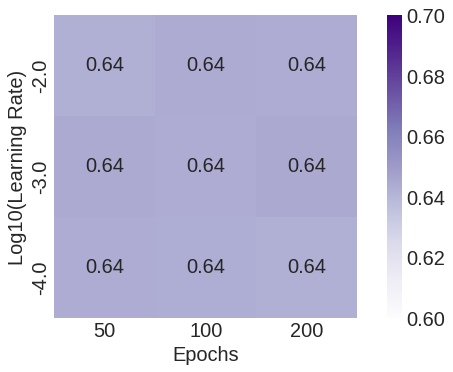

In [20]:
plt.figure(figsize=(8, 5))
sns.heatmap(asdf, annot=True, xticklabels=epochs, yticklabels=np.log10(lrs), vmin=0.6, vmax=0.7, cmap="Purples", square=True)
plt.ylim(0, 3)
plt.ylabel("Log10(Learning Rate)")
plt.xlabel("Epochs")
plt.tight_layout()
#plt.savefig("../figs/CC_TF_lr_epoch_heatmap.pdf", bbox_inches="tight")

# Not HP optimization

100%|██████████| 10/10 [01:12<00:00,  7.29s/it]


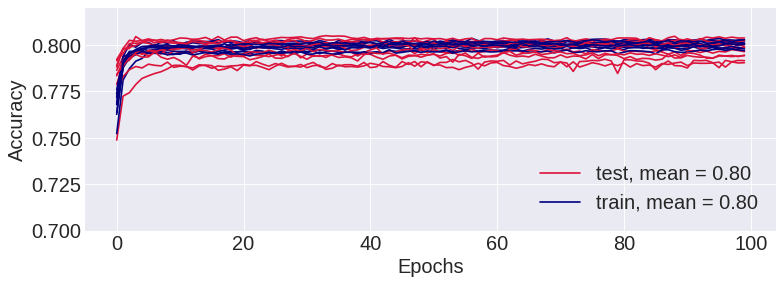

In [22]:
opti = optimizers.Adam(amsgrad=True, lr=1e-3)
def nn_reg():
    model = Sequential()
    model.add(Dense(16, input_shape=(nr_params,), activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(16, activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(1, activation="sigmoid", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss="binary_crossentropy",  metrics=["accuracy"])
    return model

acc1 = []
area1 = []
plt.figure(figsize=(10,4))
mean_acc_test = 0
mean_acc_train = 0
nr_averages = 10
for i in trange(nr_averages):
    X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data, test_size=0.3)
    Scaler = preprocessing.StandardScaler()
    X_train_scaled = Scaler.fit_transform(X_train)
    X_test_scaled = Scaler.transform(X_test)

    reg = KerasRegressor(build_fn=nn_reg, batch_size=256, epochs=100, validation_data=(X_test_scaled, Y_test), verbose=0)
    history = reg.fit(X_train_scaled, Y_train)
    mean_acc_test += history.history["val_accuracy"][-1]
    mean_acc_train += history.history["accuracy"][-1]
    plt.plot(history.history["val_accuracy"], c="crimson")
    plt.plot(history.history["accuracy"], c="navy")
plt.legend([f"test, mean = {mean_acc_test/nr_averages:.2f}", f"train, mean = {mean_acc_train/nr_averages:.2f}"], loc=4)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.7, 0.82)
plt.tight_layout()
plt.savefig("../figs/CC_epochs_TF.pdf", bbox_inches="tight")